2024-10-18

# Iterated Log Coding for Real Values

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Helper functions

In [33]:
def iterexp(signs, base=2):
    if len(signs) == 0:
        return 0.
    return signs[0] * np.exp(iterexp(signs[1:]) * np.log(base))

def iterlog(x, prec, base=2):
    if prec == 0 or x == 0.:
        return []
    return [int(np.sign(x))] + iterlog(np.log(np.abs(x)) / np.log(base), prec-1)

def signs_to_bits(signs, curr=1):
    if len(signs) == 0:
        return []
    
    next = curr * signs[0]
    return [(next+1)//2] + signs_to_bits(signs[1:], next)

def bits_to_signs(bits, last=1):
    if len(bits) == 0:
        return []
    sign = 1 if bits[0] == last else -1
    return [sign] + bits_to_signs(bits[1:], bits[0])

def iterlog_bits(x, prec, base=2):
    return signs_to_bits(iterlog(x, prec, base))

def iterexp_bits(bits, base=2):
    return iterexp(bits_to_signs(bits), base)

def pad_bits(bits, length=None):
    if length is None:
        length = len(bits) + 1
    if len(bits) >= length:
        raise ValueError("too many bits!")
    return bits + [1] + [0] * (length - 1 - len(bits))

def unpad_bits(bits):
    if not any(bits):
        raise ValueError("zero string = NaN!")
    if bits[-1] == 1:
        return bits[:-1]
    return unpad_bits(bits[:-1])

## Encoding and decoding functions

In [47]:
def decode(bits, base=2):
    return iterexp_bits(unpad_bits(bits), base)

def encode(x, length, base=2):
    return pad_bits(iterlog_bits(x, length-1, base))

## "Tests"

In [24]:
(pad_bits([0,1,1,1,0], 5))

[0, 1, 1, 1, 0, 1]

In [2]:
print(bits_to_signs(signs_to_bits([-1, 1, 1, -1, -1, -1, 1, -1])))
print(signs_to_bits(bits_to_signs([0,1,1,0,0,0,1,0,0])))


[-1, 1, 1, -1, -1, -1, 1, -1]
[0, 1, 1, 0, 0, 0, 1, 0, 0]


In [30]:
iterexp(iterlog(np.pi, 7))

np.float64(3.26354844456319)

In [48]:
encode(np.pi, 10)

[1, 1, 1, 0, 1, 1, 0, 0, 0, 1]

In [49]:
decode(encode(np.pi, 10))

np.float64(3.11876242597597)

# Choice of base: entropy and fixed point distribution

In [138]:
from scipy.stats import binomtest

In [139]:
def entropy(p):
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

In [141]:
entropy(.5), entropy(.35)

(np.float64(1.0), np.float64(0.934068055375491))

In [148]:
def posfrac(b, n=100_000, iters=100, plot=False):
    xs = np.random.randn(n)
    for _ in range(iters):
        xs = np.log(np.abs(xs)) / np.log(b)
    if plot:
        nbins = int(np.sqrt(n))
        plt.hist(xs, bins=nbins,density=True)
        plt.hist(np.log(xs[xs>0]), alpha=0.5, bins=nbins, density=True)
        plt.hist(np.log(-xs[xs<0]), alpha=0.5, bins=nbins, density=True)
        plt.show()
    return np.mean(xs), np.std(xs), np.mean(xs > 0), binomtest(k=np.sum(xs > 0), n=n).proportion_ci()

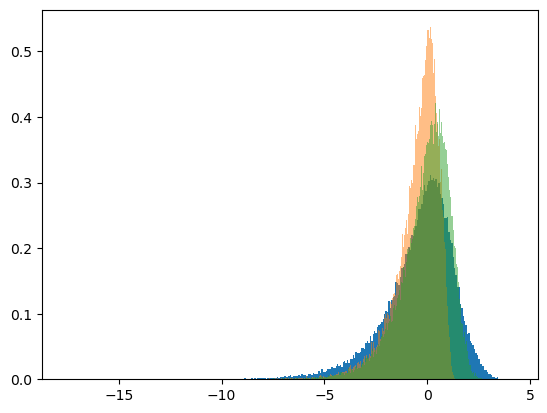

(np.float64(-0.3917184815903841),
 np.float64(1.7008660587138684),
 np.float64(0.47005),
 ConfidenceInterval(low=0.4669524956151349, high=0.47314924176516765))

In [149]:
posfrac(2., iters=1000, n=100_000, plot=True)

In [142]:
entropy(.46833)

np.float64(0.9971040475542574)

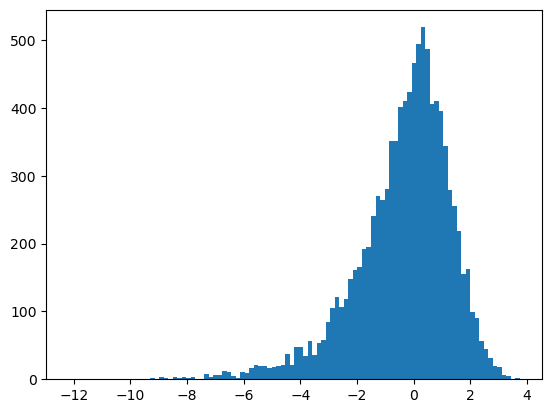

(np.float64(-0.36954555316975446),
 np.float64(1.6901207766091915),
 np.float64(0.4779),
 ConfidenceInterval(low=0.4680673942562442, high=0.4877454832015214))

In [136]:
posfrac(2., iters=200, n=10_000, plot=True)

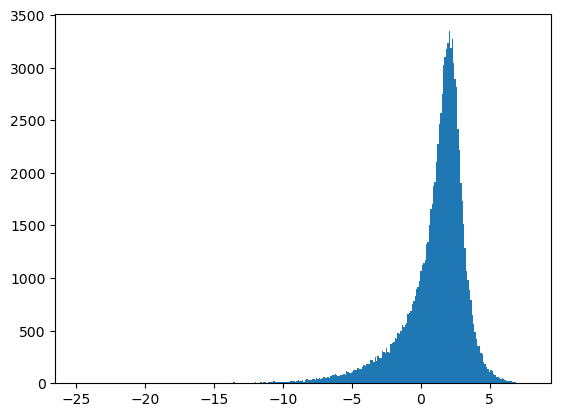

np.float64(0.78643)

In [100]:
posfrac(1.899, plot=True)

In [75]:
for b in np.linspace(1.1, 10.0, 20):
    print(b, posfrac(b))

1.1 1.0
1.568421052631579 0.69579
2.0368421052631582 0.45992
2.505263157894737 0.37047
2.973684210526316 0.32107
3.442105263157895 0.28097
3.910526315789474 0.25768
4.378947368421053 0.2393
4.847368421052632 0.22384
5.315789473684211 0.21658
5.784210526315789 0.20879
6.252631578947369 0.20089
6.721052631578948 0.19478
7.189473684210526 0.18485
7.657894736842106 0.17871
8.126315789473685 0.17331
8.594736842105263 0.16405
9.063157894736843 0.15488
9.531578947368422 0.14467
10.0 0.1354


In [69]:
p = .348
print(-1 / (p * np.log2(p) + (1-p) * np.log2(1-p)))

1.0726515571532118


# 7-bit example

In [50]:
depth = 7
for i in range(1, 2**depth):
    bits = (i >> np.flip(np.arange(depth))) & 1
    print(bits, f'{decode(bits):.7g}')


[0 0 0 0 0 0 1] -inf
[0 0 0 0 0 1 0] -65536
[0 0 0 0 0 1 1] -81.17181
[0 0 0 0 1 0 0] -16
[0 0 0 0 1 0 1] -8.577492
[0 0 0 0 1 1 0] -6.342907
[0 0 0 0 1 1 1] -4.857702
[0 0 0 1 0 0 0] -4
[0 0 0 1 0 0 1] -3.460937
[0 0 0 1 0 1 0] -3.100556
[0 0 0 1 0 1 1] -2.88577
[0 0 0 1 1 0 0] -2.665144
[0 0 0 1 1 0 1] -2.457229
[0 0 0 1 1 1 0] -2.280274
[0 0 0 1 1 1 1] -2.062328
[0 0 1 0 0 0 0] -2
[0 0 1 0 0 0 1] -1.942081
[0 0 1 0 0 1 0] -1.791163
[0 0 1 0 0 1 1] -1.706441
[0 0 1 0 1 0 0] -1.632527
[0 0 1 0 1 0 1] -1.573569
[0 0 1 0 1 1 0] -1.528956
[0 0 1 0 1 1 1] -1.47253
[0 0 1 1 0 0 0] -1.414214
[0 0 1 1 0 0 1] -1.355236
[0 0 1 1 0 1 0] -1.297032
[0 0 1 1 0 1 1] -1.250515
[0 0 1 1 1 0 0] -1.189207
[0 0 1 1 1 0 1] -1.115474
[0 0 1 1 1 1 0] -1.044274
[0 0 1 1 1 1 1] -1.000011
[0 1 0 0 0 0 0] -1
[0 1 0 0 0 0 1] -0.9999894
[0 1 0 0 0 1 0] -0.9576033
[0 1 0 0 0 1 1] -0.8964802
[0 1 0 0 1 0 0] -0.8408964
[0 1 0 0 1 0 1] -0.7996703
[0 1 0 0 1 1 0] -0.7709909
[0 1 0 0 1 1 1] -0.737879
[0 1 0 1 0 0 0] -

/tmp/ipykernel_2501887/2462023612.py:4: RuntimeWarning: overflow encountered in exp
  return signs[0] * np.exp(iterexp(signs[1:]) * np.log(base))
